# Crossword Local Search

## 概要
これはクロスワード(スケルトンパズル)自動生成用ソースをPythonにて再現できないかをテストしたものである。
main.cはpythonで代用し、計算量の多い処理は既存のcommon.cをimportして使用する。
結果やスコアの推移の視覚化も追加する。

***

## 入力データ・実行パラメータ設定
入力データを指定し、各種実行パラメータの設定を行います。
各パラメータは以下の通り：
  * `fpath`      : 入力データ(単語リスト)のファイルパス
  * `width`          : 盤面の大きさ(横)
  * `height`          : 盤面の大きさ(縦)
  * `randomSeed`       : シード値
  * `withweight` : 辞書に重みを付すかどうか(bool)
  * `takemove`   : "摂動(move)"を行うかどうか(bool)

In [1]:
fpath = "../dict/hokkaido.txt" # countries hokkaido animals kotowaza birds dinosaurs fishes sports
width = 10
height = 10
randomSeed = 5
withweight = False
takemove = True

***

## Import
必要なライブラリをimportする：

In [2]:
import numpy as np

In [3]:
from numpy.random import *
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import unicodedata
import itertools
import sys
import copy
import time

from IPython.display import display
from PIL import Image
from IPython.display import HTML
#%matplotlib inline
seed(seed = randomSeed)

***

## クラス宣言
本プログラムで使用するクラスを定義する。
見やすさのため、クラスメソッドは後から定義し、`setattr`関数でアトリビュートに追加します。


### Puzzle クラス
解となるスケルトンパズルそのものを表すクラス。
メンバ変数は以下の通り：
  * width : 盤面の大きさ(横)
  * height : 盤面の大きさ(縦)
  * enable : 配置禁止マスを保持した2次元(width*height)配列
  * cell : パズルの解を保存する2次元(width*height)配列
  * cover : セル上の文字数を保持する2次元(width*height)配列
  * coverDFS : 連結成分を探すときに使われる2次元(width*height)配列
  * usedWords : 解として使われた単語の一覧
  * usedPlcIdx : 解として使われた(後に定義する)Placeable配列上の添え字一覧
  * solSize : パズルに配置されている単語の数
  * initSol : 初期解が作られたかどうか(bool)


In [4]:
start = time.time()
class Puzzle():
    def __init__(self, width, height, msg=True):
        self.width = width
        self.height = height
        self.enable = np.ones(width*height, dtype = "bool").reshape(height,width)
        self.cell = np.full(width*height, "", dtype = "unicode").reshape(height,width)
        self.cover = np.zeros(width*height, dtype = "int64").reshape(height,width)
        self.coverDFS = np.zeros(width*height, dtype = "int64").reshape(height,width)
        self.usedWords = np.full(width*height, "", dtype = "U%d" % max(width,height))
        self.usedPlcIdx = np.full(width*height, -1, dtype = "int64")
        self.solSize = 0
        self.initSol = False

        ## Message
        if msg == True:
            print("Puzzle object has made.")
            print(" - width       : %d" % self.width)
            print(" - height      : %d" % self.height)
            print(" - cell' shape : (width, height) = (%d,%d)" % (self.cell.shape[0], self.cell.shape[1]))

    def copy(self, puzzle):
        self.width = copy.deepcopy(puzzle.width)
        self.height = copy.deepcopy(puzzle.height)
        self.enable = copy.deepcopy(puzzle.enable)
        self.cell = copy.deepcopy(puzzle.cell)
        self.cover = copy.deepcopy(puzzle.cover)
        self.coverDFS = copy.deepcopy(puzzle.coverDFS)
        self.usedWords = copy.deepcopy(puzzle.usedWords)
        self.usedPlcIdx = copy.deepcopy(puzzle.usedPlcIdx)
        self.solSize = copy.deepcopy(puzzle.solSize)
        self.initSol = copy.deepcopy(puzzle.initSol)

In [5]:
puzzle = Puzzle(width, height)

Puzzle object has made.
 - width       : 10
 - height      : 10
 - cell' shape : (width, height) = (10,10)


### Dictionary クラス
入力した単語リストを整理して保持するクラス。
メンバ変数は以下の通り：
  * fpath : 入力データのファイルパス
  * size : 辞書の大きさ(単語数)
  * dictType : 辞書のタイプ("English"/"Japanese")
  * data : 入力データ配列

In [6]:
class Dictionary():
    def __init__(self, fpath, msg=True):
        self.fpath = fpath
        print("Dictionary object has made.")
        
        ## Read
        print(" - READING DICTIONARY...")
        file = open(self.fpath, 'r', encoding='utf-8')
        self.data = file.readlines()
        file.close()
        
        # Get a size of dictionary
        self.size = len(self.data)
        
        # Check dictionary type(English/Japanese)
        uniName = unicodedata.name(self.data[0][0])[0:10]
        if "HIRAGANA" in uniName or "KATAKANA" in uniName:
            self.dictType = "Japanese"
        elif "LATIN" in uniName:
            self.dictType = "English"
            #self.data = [s.upper() for s in self.data]
        elif "CJK" in uniName:
            self.dictType = "Kanji"

        # Remove "\n"
        def removeNewLineCode(word):
            return word.rstrip("\n")
        self.data = list(map(removeNewLineCode, self.data))

        ## Message
        if msg == True:
            print(" - file path         : %s" % self.fpath)
            print(" - dictionary size   : %d" % self.size)
            print(" - dictionary type   : %s" % self.dictType)
            print(" - top of dictionary : %s" % self.data[1])

In [7]:
dic = Dictionary(fpath)

Dictionary object has made.
 - READING DICTIONARY...
 - file path         : ../dict/hokkaido.txt
 - dictionary size   : 179
 - dictionary type   : Japanese
 - top of dictionary : あかいがわ


### Placeable クラス
辞書内のすべての単語に対して、それぞれの単語が配置可能(placeable)な位置の一覧を作る。これは`Puzzle`クラスと`Dictionary`クラスの両方の要素を用いて行われる。

配置可能な位置は、単語の先頭文字の座標で指定する。ここでは、パズルの左上を(0,0)、右上を(n,0)、左下を(0,n)、右下を(n,n)とする。
例えば、大きさが5×5のパズル上に`Dictionary`クラスの5番目に格納された長さ4文字の単語「HOGE」を配置しようとした場合、配置可能な位置は
  * 横向きの場合：(0,0),(0,1),(0,2),(0,3)(0,4),(1,0),(1,1),(1,2),(1,3),(1,4)の10マス。
  * 縦向きの場合：(0,0),(1,0),(2,0),(3,0)(4,0),(0,1),(1,1),(2,1),(3,1),(4,1)の10マス。
よって。配置する場合のパターンは全部で20通りになる。

In [8]:
#display(Image.open("fig/puzzles.png"))

これらの情報は次のフォーマットで整理される：
  * k : 単語番号(辞書内の何番目の単語か)
  * div : 単語を置く向き(0: 縦, 1: 横)
  * j : 単語の先頭文字のx座標
  * i : 単語の先頭文字のy座標

In [9]:
"""
pd.DataFrame([[5,0,0,0],[5,0,0,1],[5,0,0,2],[5,0,0,3],[5,0,0,4],
              [5,0,1,0],[5,0,1,1],[5,0,1,2],[5,0,1,3],[5,0,1,4],
              [5,1,0,0],[5,1,1,0],[5,1,2,0],[5,1,3,0],[5,0,4,0],
              [5,1,0,1],[5,1,1,1],[5,1,2,1],[5,1,3,1],[5,1,4,1],],
             columns=["k","div","j","i"],
             index=["p1","p2","p3","p4","p5","p6","p7","p8","p9","p10",
                    "p11","p12","p13","p14","p15","p16","p17","p18","p19","p20"]
            )
"""

'\npd.DataFrame([[5,0,0,0],[5,0,0,1],[5,0,0,2],[5,0,0,3],[5,0,0,4],\n              [5,0,1,0],[5,0,1,1],[5,0,1,2],[5,0,1,3],[5,0,1,4],\n              [5,1,0,0],[5,1,1,0],[5,1,2,0],[5,1,3,0],[5,0,4,0],\n              [5,1,0,1],[5,1,1,1],[5,1,2,1],[5,1,3,1],[5,1,4,1],],\n             columns=["k","div","j","i"],\n             index=["p1","p2","p3","p4","p5","p6","p7","p8","p9","p10",\n                    "p11","p12","p13","p14","p15","p16","p17","p18","p19","p20"]\n            )\n'

メンバ変数は以下の通り：
  * size : Placeableオブジェクトの大きさ
  * width : 引数のパズルの横幅
  * height : 引数のパズルの縦幅
  * div : Placeable成分の文字列の方向
  * k : Placeable成分の文字の番号
  * i : Placeable成分のy方向の座標
  * j : Placeable成分のx方向の座標
  * invP : Placeableオブジェクトの逆写像

In [10]:
class Placeable():
    def __init__(self, puzzle, dic, msg=True):
        self.size = 0
        self.width = puzzle.width
        self.height = puzzle.height
        self.div = np.zeros(2*dic.size*self.width*self.height, dtype='int64')
        self.k = np.zeros(2*dic.size*self.width*self.height, dtype='int64')
        self.i = np.zeros(2*dic.size*self.width*self.height, dtype='int64')
        self.j = np.zeros(2*dic.size*self.width*self.height, dtype='int64')
        self.invP = np.zeros(2*dic.size*self.width*self.height, dtype='int64').reshape(2,self.height,self.width,dic.size)
        dicSize = dic.size

        for div in range(2):
            for k in range(dicSize):
                if div == 0:
                    iMax = self.height - len(dic.data[k]) + 1
                    jMax = self.width
                elif div == 1:
                    iMax = self.height
                    jMax = self.width - len(dic.data[k]) + 1
                for i in range(iMax):
                    for j in range(jMax):
                        self.div[self.size] = div
                        self.k[self.size] = k
                        self.i[self.size] = i
                        self.j[self.size] = j
                        self.invP[div,i,j,k] = self.size
                        self.size += 1
        if msg == True:
            print("Placeable object has made.")
            print(" - placeable size : %d/%d(max shape)" % (self.size, self.div.size))

In [11]:
plc = Placeable(puzzle, dic)

Placeable object has made.
 - placeable size : 25380/35800(max shape)


### ObjectiveFunction クラス
生成したパズルは何らかの指標で定量的にその良し悪しを評価する必要があります。
そのパズルの良し悪しの指標として、「目的関数」を定義します。
目的関数は、パズルの初期解が得られてから、そのパズルを改善していくために使われます。
目的関数には様々な指標が考えられるため、それらを管理する`ObjectiveFunction`クラスを定義します：

In [12]:
class ObjectiveFunction():
    def __init__(self, puzzle, msg=True):
        self.puzzle = puzzle
        self.flist = ["solSize",
                      "crossCount",
                      "fillCount",
                      "maxConnectedEmptys"]
        self.registeredFuncs = []
        if msg == True:
            print("ObjectiveFunction object has made.")

In [13]:
objFunc = ObjectiveFunction(puzzle)

ObjectiveFunction object has made.


`flist`は後ほど実装する目的関数名をリスト化したものです。`ObjectiveFunction`クラスについての詳しい説明と実装は後ほど行われます。

### Optimizer クラス
目的関数を指標にパズルを改善していく際、どのような手法で最適化していくのかも重要なカギになります。
この種の問題は「離散最適化問題(組み合わせ最適化)」と呼ばれ、巡回セールスマン問題などと近い分類に当たります。この手の問題で使われる最適化手法は「局所探索法」や「焼きなまし法」などが用いられます。
最適化手法はアイデア次第で様々なものが考えられるため、これら管理する`Optimizer`クラスを定義しておきましょう：

In [14]:
class Optimizer():
    def __init__(self, msg=True):
        self.methodList = ["localSearch", "iterativeLocalSearch"]
        self.method = ""
        if msg == True:
            print("Opimizer object has made.")

In [15]:
optimizer = Optimizer()

Opimizer object has made.


`Optimizer`クラスについての詳しい説明と実装は後ほど行われます。
また、`ObjectiveFunction`オブジェクトと`Optimizer`オブジェクトは同時に`Puzzle`オブジェクトにコンパイルすることで、`Puzzle`オブジェクトから呼び出しが可能になります。
目的関数と最適化手法をパズルにコンパイルするための`compile`メソッドも後ほど実装します。

***
## パズル生成
ここから、実際にパズルを生成していく。
まずは、`placeable`オブジェクトからランダムに単語の配置可能位置を取得し、パズルの盤面に単語を詰められなくなるまで詰めます。
単語を詰めるための関数として、`add`メソッドを`Puzzle`クラスに追加します。その前に、`add`メソッド内で呼ぶ、単語が配置可能かどうかをBoolianで返す`isEnabledAdd`メソッドを定義します：

In [16]:
### isEnabledAdd
def isEnabledAdd(self, div, i, j, word, wLen):
    # If 0 words used, return True
    if self.solSize == 0:
        return True

    # If the same word is in use, return False
    if np.any(self.usedWords == word):
        return False

    # If the word does not fit in the puzzle, return False
    if div == 0 and i+wLen > self.height:
        return False
    if div == 1 and j+wLen > self.width:
        return False

    # US/USA, DOMINICA/DOMINICAN probrem
    if div == 0:
        emptys = self.cell[i:i+wLen,j] == ""
        if np.all(emptys == True) or np.any(self.enable[i:i+wLen,j] == False) or np.all(emptys == False):
            return False
    if div == 1:
        emptys = self.cell[i,j:j+wLen] == ""
        if np.all(emptys == True) or np.any(self.enable[i,j:j+wLen] == False) or np.all(emptys == False):
            return False

    # Judge whether correct intersection
    where = np.where(emptys == False)[0]
    if div == 0:
        jall = np.full(where.size, j, dtype = "int64")
        if np.any(self.cell[where+i,jall] != np.array(list(word))[where]):
            return False
    if div == 1:
        iall = np.full(where.size, i, dtype = "int64")
        if np.any(self.cell[iall,where+j] != np.array(list(word))[where]):
            return False

    # If neighbor cells are filled except at the intersection, return False
    where = np.where(emptys == True)[0]
    if div == 0:
        jall = np.full(where.size, j, dtype = "int64")
        # Left side
        if j > 0 and np.any(self.cell[where+i,jall-1] != ""):
            return False
        # Right side
        if j < self.width-1 and np.any(self.cell[where+i,jall+1] != ""):
            return False
    if div == 1:
        iall = np.full(where.size, i, dtype = "int64")
        # Upper
        if i > 0 and np.any(self.cell[iall-1,where+j] != ""):
            return False
        # Lower
        if i < self.height-1 and np.any(self.cell[iall+1,where+j] != ""):
            return False

    # If the preceding and succeeding cells are already filled
    if div == 0:
        if i > 0 and self.cell[i-1,j] != "":
            return False
        if i+wLen < self.height and self.cell[i+wLen,j] != "":
            return False
    if div == 1:
        if j > 0 and self.cell[i,j-1] != "":
            return False
        if j+wLen < self.width and self.cell[i,j+wLen] != "":
            return False

    # If Break through the all barrier, return True
    return True

# Set attribute to Puzzle class
setattr(Puzzle, "isEnabledAdd", isEnabledAdd)

次に、所望の単語をパズルに配置する`add`メソッドを定義します。
`add`メソッドは次の機能を持ちます：
  * `add`メソッドの引数は [ Dictionary, Placeable, 単語を置く向き, 頭文字のy座標, 頭文字のx座標, 置く単語 ] で指定します。
  * 指定した位置に単語が置ける場合は置き、置けない場合は何もしません。

実際に、`add`メソッドを定義しましょう：

In [17]:
### add
def add(self, dic, plc, div, i, j, word):
    # Get the word length
    wLen = len(word)

    # Judge whether adding is enabled
    if self.isEnabledAdd(div, i, j, word, wLen) == False:
        return
    
    # Put the word to puzzle
    if div == 0:
        self.cell[i:i+wLen,j] = list(word)[0:wLen]
    if div == 1:
        self.cell[i,j:j+wLen] = list(word)[0:wLen]

    # Set the prohibited cell before and after placed word
    if div == 0:
        if i > 0:
            self.enable[i-1,j] = False
        if i+wLen < self.height:
            self.enable[i+wLen,j] = False
    if div == 1:
        if j > 0:
            self.enable[i,j-1] = False
        if j+wLen < self.width:
            self.enable[i,j+wLen] = False
    
    # Update cover array
    if div == 0:
        self.cover[i:i+wLen,j] += 1
    if div == 1:
        self.cover[i,j:j+wLen] += 1
    
    # Update properties
    self.usedPlcIdx[self.solSize] = plc.invP[div, i, j, dic.data.index(word)]
    self.usedWords[self.solSize] = word
    self.solSize += 1
    return
# Set attribute to Puzzle class  
setattr(Puzzle, "add", add)

さあ、`add`メソッドが定義できたので、早速パズルを生成して、初期解を作りましょう。
`Puzzle`オブジェクトのメソッドとして初期解を得るための`firstSolve`メソッドを定義し、その中で`add`メソッドを呼ぶことにします。
  * `firstSolve`メソッドの引数は [ `Dictionary`オブジェクト, `Placeable`オブジェクト ] です。
  * `firstSolve`メソッドにより、初期解が`Puzzle`オブジェクトの`sol`プロパティに保存されます。

In [18]:
def firstSolve(self, dic, plc):
    # Check the initSol
    if self.initSol:
        sys.stderr.write("error: 'firstSolve' method has already called.")
        return
    
    # Make a random index of plc    
    randomIndex = np.arange(plc.size)
    shuffle(randomIndex)
    
    # Add as much as possible 
    solSizeTmp = -1
    while self.solSize != solSizeTmp:
        solSizeTmp = self.solSize
        for t in randomIndex:
            self.add(dic, plc, plc.div[t], plc.i[t], plc.j[t], dic.data[plc.k[t]])
    self.initSol = True
setattr(Puzzle, "firstSolve", firstSolve)

In [19]:
puzzle.firstSolve(dic, plc)

結果が気になりますよね。
結果を確認するための`show`メソッドを定義します：

In [20]:
def show(self, ndarray):    
    styles = [
        dict(selector="th", props=[("font-size", "90%"),
                                   ("text-align", "center"),
                                   ("color", "#ffffff"),
                                   ("background", "#777777"),
                                   ("border", "solid 1px white"),
                                   ("width", "30px"),
                                   ("height", "30px")]),
        dict(selector="td", props=[("font-size", "105%"),
                                   ("text-align", "center"),
                                   ("color", "#161616"),
                                   ("background", "#dddddd"),
                                   ("border", "solid 1px white"),
                                   ("width", "30px"),
                                   ("height", "30px")]),
        dict(selector="caption", props=[("caption-side", "bottom")])
    ]
    df = pd.DataFrame(ndarray)
    df.to_clipboard()
    df = (df.style.set_table_styles(styles)
          .set_caption("Puzzle(%d,%d), Seed:%d, solSize:%d Dictionary:[%s]" % (self.width, self.height, randomSeed, self.solSize, fpath)))
    display(df)
setattr(Puzzle, "show", show)

早速使ってみましょう。見たい結果を`show`メソッドの引数として与えます。
ここでは`puzzle.cell`を見てみます(`puzzle.cover`や`puzzle.enable`も可能)：

In [21]:
puzzle.show(puzzle.cell)

,0,1,2,3,4,5,6,7,8,9
0,,,,し,ん,ひ,だ,か,,あ
1,,,,か,,,,み,か,さ
2,,,し,べ,つ,,,し,,ひ
3,,,ん,,,,,ほ,,か
4,,お,と,べ,,は,ぼ,ろ,,わ
5,,,く,,,こ,,,,
6,,,,,ひ,だ,か,,,
7,,,,,,て,,,,
8,,,,,,,,,,
9,,,,,,,,,,


まだ改善の余地がありますが、一つの島で繋がったパズルが出来上がっていますね。ちなみに、`show`メソッドを呼ぶと自動的にクリップボードに保存されるようになるので、結果をすぐに誰かと共有したい場合はそれをペーストするだけでできます。

***

## 目的関数
さて、今できた解はまだ未熟であり、改善の余地があるように見えると思います。
ここで、この解の良し悪しを定量的に判断する必要があります。
この定量的な解の良し悪し指標を「目的関数」として定義します。
目的関数には様々なものが考えられます：

* 解に使われた単語数(solSize)
* 単語のクロス数
* 文字で埋まっているセルの個数
* 文字なしマスの連結数の最大値(を最小化)

これ以外にも様々な目的関数が考えられるでしょう。そして、これらの目的関数は優先順位をつけて共存させることも可能です。後ほど実装する最適化手法は、これらの値を「スコア」として受け、それを最大化するように働きます。なので、4つ目の「文字なしマスの連結数の最大値」は、パズル全マスからその値を引いたものをスコアとして返すように設計します。

早速、目的関数を一つ作って、`ObjectiveFunction`クラスのアトリビュートとして設定してみましょう。まずは、最も単純な「解に使われた単語数」を返す目的関数を実装します：

In [22]:
def solSize(self):
    return self.puzzle.solSize
setattr(ObjectiveFunction, "solSize", solSize)

次に、単語のクロス数を判定して返す目的関数を実装します：

In [23]:
def crossCount(self):
    return np.sum(self.puzzle.cover == 2)
setattr(ObjectiveFunction, "crossCount", crossCount)

次に、文字で埋まっているセルの個数を返す目的関数を実装します：

In [24]:
def fillCount(self):
    return np.sum(self.puzzle.cover >= 1)
setattr(ObjectiveFunction, "fillCount", fillCount)

それでは、それぞれのスコアを見てみましょう：

In [25]:
print("solSize: %d" % objFunc.solSize())
print("crossCount: %d" % objFunc.crossCount())
print("fillCount: %d" % objFunc.fillCount())

solSize: 11
crossCount: 10
fillCount: 31


先ほどの初期解で結果が正しいかを確認してください。

目的関数には「文字なしマスの連結数の最大値」なども考えられます。しかし、この「連結数」を数えるのは少し工夫が必要です。連結数のカウントには「深さ優先探索(Depth First Search:DFS)」を用います。
* `DFS`メソッドはセルの値が1でそれ以外が0の2次元配列(coverDFS)を引数にとり、引数で与えられたセルと連結したセルには全て同じ番号(ccl)を振ります。
* `DFS`メソッドは引数に[ coverDFS, 今見る行, 今見る列, 島番号]をとります。

後ほど、`DFS`メソッドは目的関数以外の場所でも使うため、`Puzzle`クラスのメソッドとして登録しておきます：

In [26]:
def DFS(self, i, j, ccl):
    self.coverDFS[i,j] = ccl
    if i>0 and self.coverDFS[i-1,j] == 1:
        self.DFS(i-1, j, ccl)
    if i<self.height-1 and self.coverDFS[i+1,j] == 1:
        self.DFS(i+1, j, ccl)
    if j>0 and self.coverDFS[i,j-1] == 1:
        self.DFS(i, j-1, ccl)
    if j<self.width-1 and self.coverDFS[i,j+1] == 1:
        self.DFS(i, j+1, ccl)
setattr(Puzzle, "DFS", DFS)

`DFS`メソッドは引数で与えられたセルに連結した島しか判定しません。
文字なしマスの最大連結数を見るためには、全ての島に対してDFSを使って番号を振る必要があります。

さて、この`DFS`メソッドを使って文字なしマスの最大連結数を取り出す`maxConnectedEmptys`メソッドを定義しましょう(上でも述べたとおり、全マス数から最大連結数を引いたものをスコアとして返します)：

In [27]:
def maxConnectedEmptys(self):
    ccl = 2
    self.puzzle.coverDFS = np.where(self.puzzle.cover == 0, 1, 0)
    for i, j in itertools.product(range(self.puzzle.height), range(self.puzzle.width)):
        if self.puzzle.coverDFS[i,j] == 1:
            self.puzzle.DFS(i, j, ccl)
            ccl += 1
    score = self.puzzle.width*self.puzzle.height - np.max(np.bincount(self.puzzle.coverDFS.flatten())[1:])
    return score
setattr(ObjectiveFunction, "maxConnectedEmptys", maxConnectedEmptys)

早速結果を見てみましょう：

In [28]:
print("maxConnectedEmptys: %d" % objFunc.maxConnectedEmptys())

maxConnectedEmptys: 32


次に、これらの目的関数をどの順番で見ていくかの優先順位をつけて、`ObjectiveFunction`オブジェクトに覚えさせていきます。
ここでは、そのための`register`メソッドを定義します：

In [29]:
def register(self, funcNames, msg=True):
    for funcName in funcNames:
        if funcName not in self.flist:
            sys.stderr.write("error: ObjectiveFunction class doesn't have '%s' function." % funcName)
            sys.exit()
        if msg == True:
            print(" - '%s' function has registered." % funcName)
    self.registeredFuncs = funcNames
    return
setattr(ObjectiveFunction, "register", register)

In [30]:
objFunc.register(["solSize", "crossCount", "fillCount", "maxConnectedEmptys"])

 - 'solSize' function has registered.
 - 'crossCount' function has registered.
 - 'fillCount' function has registered.
 - 'maxConnectedEmptys' function has registered.


この場合、"solSize"から評価され、最後に”fillCount”が評価されます。
次に、こうして登録した目的関数値をスコアとして返す`getScore`メソッドを定義します：

In [31]:
def getScore(self, i, all=False):
    if all:
        scores=np.zeros(len(self.registeredFuncs), dtype="int64")
        for n in range(scores.size):
            scores[n] = eval("self.%s()" % self.registeredFuncs[n])
        return scores
    return eval("self.%s()" % self.registeredFuncs[i])
setattr(ObjectiveFunction, "getScore", getScore)

このメソッドは引数`i`を指定すれば`i`番目のスコアが得られ、`all=True`を与えればスコアを一覧で返します。
それでは、それぞれ試してみましょう：

In [32]:
print("score(0): %s" % objFunc.getScore(0))
print("scores: %s" % objFunc.getScore(0, all=True))

score(0): 11
scores: [11 10 31 32]



これで、`ObjectiveFunction`クラスを`Puzzle`クラスにコンパイルする準備はできました。
しかし、コンパイルは最適化手法(`Optimizer`クラス)と一緒にコンパイルする設計にするため、この後は`Optimizer`クラスの中身を作っていきましょう。

***

## 最適化手法
ここでは、設定した目的関数値を最大化/最小化するための手法を実装していきます。まずは、数ある最適化手法の中から「局所探索法」を実装します。これは、このノートのタイトルにもある「LocalSearch」と呼ばれる手法で、組み合わせ最適化問題を解く近似解法として代表的なものです。

ここで、局所探索法に関して簡単に解説します。
まず、今までの流れをおさらいします。
  1. ランダムに単語を一つパズルに配置する。
  2. その単語と必ずクロスするように、可能なだけランダムに単語を配置していく。
  3. これ以上配置できない状態になったら、それを初期解とする。
  4. 設定した目的関数で解の良さを判定する。
よろしいでしょうか。それではここから、初期解の「近傍領域」に存在する「近傍解」を探していきます。
近傍解とは、初期解に似たような解を指します。よって、近傍解は初期解を元に得る必要があります。
しかし、初期解にはこれ以上単語を配置することはできません。
そのため、まずは初期解から単語をランダムに抜いていきます。そして、単語の連結性が崩れ、1つだった単語の島が2つ以上に分離したら、そこで単語を抜く処理を止めます。

ここで一旦、盤面に置かれた単語を抜くというここまでの処理を`drop`メソッドとして定義します：

In [33]:
def drop(self, puzzle, p, indexOfUsedPlcIdx):
    # Get div, i, j, wLen
    div = self.plc.div[p]
    i = self.plc.i[p]
    j = self.plc.j[p]
    wLen = len(self.dic.data[self.plc.k[p]])
    
    # If '2' is aligned in the cover array, continue to next loop
    if div == 0:
        if np.any(np.diff(np.where(puzzle.cover[i:i+wLen,j] == 2)[0]) == 1):
            return
    if div == 1:
        if np.any(np.diff(np.where(puzzle.cover[i,j:j+wLen] == 2)[0])==1):
            return
    # Pull out a word
    if div == 0:
        puzzle.cover[i:i+wLen,j] -= 1
        where = np.where(puzzle.cover[i:i+wLen,j] == 0)[0]
        jall = np.full(where.size, j, dtype="int64")
        puzzle.cell[i+where,jall] = ""
    if div == 1:
        puzzle.cover[i,j:j+wLen] -= 1
        where = np.where(puzzle.cover[i,j:j+wLen] == 0)[0]
        iall = np.full(where.size, i, dtype="int64")
        puzzle.cell[iall,j+where] = ""
    # Update usedPlcIdx and solSize
    puzzle.usedWords[indexOfUsedPlcIdx] = ""
    puzzle.usedPlcIdx[indexOfUsedPlcIdx] = -1
    puzzle.solSize -= 1
    # Release prohibited cells
    removeFlag = True
    if div == 0:
        if i > 0:
            if i > 2 and np.all(puzzle.cell[[i-3,i-2],[j,j]] != ""):
                removeFlag = False
            if j > 2 and np.all(puzzle.cell[[i-1,i-1],[j-2,j-1]] != ""):
                removeFlag = False
            if j < puzzle.width-2 and np.all(puzzle.cell[[i-1,i-1],[j+1,j+2]] != ""):
                removeFlag = False
            if removeFlag == True:
                puzzle.enable[i-1,j] = True
        if i+wLen < puzzle.height:
            if i+wLen < puzzle.height-2 and np.all(puzzle.cell[[i+wLen+1,i+wLen+2],[j,j]] != ""):
                removeFlag = False
            if j > 2 and np.all(puzzle.cell[[i+wLen,i+wLen],[j-2,j-1]] != ""):
                removeFlag = False
            if j < puzzle.width-2 and np.all(puzzle.cell[[i+wLen,i+wLen],[j+1,j+2]] != ""):
                  removeFlag = False
            if removeFlag == True:
                puzzle.enable[i+wLen,j] = True
    if div == 1:
        if j > 0:
            if j > 2 and np.all(puzzle.cell[[i,i],[j-3,j-2]] != ""):
                removeFlag = False
            if i > 2 and np.all(puzzle.cell[[i-2,i-1],[j-1,j-1]] != ""):
                removeFlag = False
            if i < puzzle.height-2 and np.all(puzzle.cell[[i+1,i+2],[j-1,j-1]] != ""):
                removeFlag = False
            if removeFlag == True:
                puzzle.enable[i,j-1] = True
        if j+wLen < puzzle.width:
            if j+wLen < puzzle.width-2 and np.all(puzzle.cell[[i,i],[j+wLen+1,j+wLen+2]] != ""):
                removeFlag = False
            if i > 2 and np.all(puzzle.cell[[i-2,i-1],[j+wLen,j+wLen]] != ""):
                removeFlag = False
            if i < puzzle.height-2 and np.all(puzzle.cell[[i+1,i+2],[j+wLen,j+wLen]] != ""):
                removeFlag = False
            if removeFlag == True:
                puzzle.enable[i,j+wLen] = True
setattr(Optimizer, "drop", drop)

次に、これを用いて単語を抜いた後、残った島の中で一番面積(+クロス数)の大きい島以外を全て消します。
これによって、初期解の情報をある程度保ちつつ、単語を抜いたことになります。

そこまでできたら、初期解を得た時と同じように、今の盤面に配置可能な単語をランダムに配置していき、
これ以上配置できなくなった時点を「近傍解」とします。

それでは、近傍解を得る`getNeighborSolution`メソッドを定義します：

In [34]:
def getNeighborSolution(self, tmpPuzzle):   
    # If solSize = 0, return
    if tmpPuzzle.solSize == 0:
        return
    
    # Make a random index of solSize  
    randomIndex = np.arange(tmpPuzzle.solSize)
    shuffle(randomIndex)
    
    # Drop words until connectivity collapses
    for r, p in enumerate(tmpPuzzle.usedPlcIdx[randomIndex]):
        self.drop(tmpPuzzle, p, randomIndex[r])
        # End with connectivity breakdown
        tmpPuzzle.coverDFS = np.where(tmpPuzzle.cover >= 1, 1, 0)
        ccl = 2
        for i, j in itertools.product(range(tmpPuzzle.height), range(tmpPuzzle.width)):
            if tmpPuzzle.coverDFS[i,j] == 1:
                self.puzzle.DFS(i, j, ccl)
                ccl += 1
        if ccl-2 >= 2:
            break
    # Stuff the deleted index
    whereDelete = np.where(tmpPuzzle.usedPlcIdx == -1)[0]
    for p in whereDelete:
        tmpPuzzle.usedWords = np.append(np.delete(tmpPuzzle.usedWords, p), "")
        tmpPuzzle.usedPlcIdx = np.append(np.delete(tmpPuzzle.usedPlcIdx, p), -1)
        whereDelete -= 1

    # Kick
    # If solSize = 0 after droping, return
    if tmpPuzzle.solSize == 0:
        return
    
    # Define 'largestCCL' witch has the largest score(fillCount+crossCount)
    cclScores = np.zeros(ccl-2, dtype="int64")
    for c in range(ccl-2):
        cclScores[c] = np.sum(np.where(tmpPuzzle.coverDFS == c+2, tmpPuzzle.cover, 0))
    largestCCL = np.argmax(cclScores) + 2
    
    # Erase elements except CCL ('kick' in C-program)
    for idx, p in enumerate(tmpPuzzle.usedPlcIdx[:self.puzzle.solSize]):
        if p == -1:
            continue
        if tmpPuzzle.coverDFS[self.plc.i[p],self.plc.j[p]] != largestCCL:
            self.drop(tmpPuzzle, p, idx)

    # Stuff the deleted index
    whereDelete = np.where(tmpPuzzle.usedPlcIdx == -1)[0]
    for p in whereDelete:
        tmpPuzzle.usedWords = np.append(np.delete(tmpPuzzle.usedWords, p), "")
        tmpPuzzle.usedPlcIdx = np.append(np.delete(tmpPuzzle.usedPlcIdx, p), -1)
        whereDelete -= 1
    
    # Make a random index of plc    
    randomIndex = np.arange(self.plc.size)
    shuffle(randomIndex)
    
    # Add as much as possible 
    solSizeTmp = -1
    while tmpPuzzle.solSize != solSizeTmp:
        solSizeTmp = tmpPuzzle.solSize
        for t in randomIndex:
            tmpPuzzle.add(self.dic, self.plc, self.plc.div[t], self.plc.i[t], self.plc.j[t], self.dic.data[self.plc.k[t]])
setattr(Optimizer, "getNeighborSolution", getNeighborSolution)

さあ、ここまでで局所探索法を行う準備が整いました。
局所探索法では近傍解を探し、そのスコアが暫定解よりも高ければ暫定解を更新し、低ければ近傍解を棄却します。
それを指定回数(epock数)だけ繰り返し、それが終わった時点での暫定解を「局所最適解」として得ます。
厳密にはそこでの最適解かはわかりませんが、この解は近似的な最適解と言えるでしょう。

それでは、局所探索法を行う`localSearch`メソッドを定義しましょう：

In [35]:
def localSearch(self, epock, show=True, move=False):
    if show:
        print("Interim solution:")
        self.puzzle.show(self.puzzle.cell)
    for ep in range(1,epock+1):
        print("Epock %d/%d" % (ep, epock))
        ## Obtain a neighbor solution
        # Copy the Puzzle object and objective function
        self.tmpPuzzle.copy(self.puzzle)
        tmpObjFunc = ObjectiveFunction(self.tmpPuzzle, msg=False)
        tmpObjFunc.register(self.objFunc.registeredFuncs, msg=False)
    
        # Get neigh solution by drop->kick->add
        self.getNeighborSolution(self.puzzle)
    
        # Repeat if the score is high
        for funcNum in range(len(tmpObjFunc.registeredFuncs)):
            puzzleScore = self.objFunc.getScore(funcNum)
            tmpPuzzleScore = tmpObjFunc.getScore(funcNum)
            if puzzleScore > tmpPuzzleScore:
                print(" Improved - score[%d]: %d" % (funcNum,puzzleScore))
                if show:
                    self.puzzle.show(self.puzzle.cell)
                break
            if puzzleScore < tmpPuzzleScore:
                self.puzzle.copy(self.tmpPuzzle)
                print(" Stayed")
                break
        else:
            print(" Replaced(same score) - score[%d]: %d" % (funcNum,puzzleScore))
            if show:
                self.puzzle.show(self.puzzle.cell)
    return
setattr(Optimizer, "localSearch", localSearch)

これで局所探索法のメソッドが書けました。

しかし、このメソッドを`Optimizer`オブジェクトから直に呼ぶのではなく、`Puzzle`オブジェクトのメソッド内で呼べるようにします。そのために、`ObjectiveFunction`オブジェクトと共に`Puzzle`オブジェクトにコンパイルします。そのための`compile`メソッドを`Puzzle`クラスに追加しましょう：

In [36]:
def setMethod(self, methodName, msg=True):
    if methodName not in self.methodList:
        sys.stderr.write("error: Optimizer class doesn't have '%s' method." % methodName)
        sys.exit()
    if msg:
        print(" - '%s' method has registered." % methodName)
    self.method = methodName
setattr(Optimizer, "setMethod", setMethod)

In [37]:
optimizer.setMethod("localSearch")

 - 'localSearch' method has registered.


In [38]:
def compiling(self, dictionary=None, placeable=None, objFunc=None, optimizer=None, msg=True):
    if dictionary is None or placeable is None or objFunc is None or optimizer is None:
        sys.stderr.write("error: usage .compile(dictionary, placeable, objFunc, optimizer)")
        sys.exit()
    self.objFunc = objFunc
    self.optimizer = optimizer
    self.optimizer.puzzle = self
    self.optimizer.tmpPuzzle = Puzzle(self.width, self.height, msg=False)
    self.optimizer.dic = dictionary
    self.optimizer.plc = placeable
    self.optimizer.objFunc = objFunc
    
    if msg:
        print("compile succeeded.")
        print(" --- objective functions:")
        for funcNum in range(len(objFunc.registeredFuncs)):
            print("  |-> %d. %s" % (funcNum, objFunc.registeredFuncs[funcNum]))
        print(" --- optimizer: %s" % optimizer.method)
setattr(Puzzle, "compiling", compiling)

In [39]:
puzzle.compiling(dictionary=dic, placeable=plc, objFunc=objFunc, optimizer=optimizer)

compile succeeded.
 --- objective functions:
  |-> 0. solSize
  |-> 1. crossCount
  |-> 2. fillCount
  |-> 3. maxConnectedEmptys
 --- optimizer: localSearch


In [40]:
def solve(self, *, epock=0):
    if epock == 0:
        sys.stderr.write("error: usage(example) .solve(epock=10)")
        sys.exit()
    self.optimizer.localSearch(epock)
setattr(Puzzle, "solve", solve)

In [41]:
puzzle.solve(epock=10)

Interim solution:


,0,1,2,3,4,5,6,7,8,9
0,,,,し,ん,ひ,だ,か,,あ
1,,,,か,,,,み,か,さ
2,,,し,べ,つ,,,し,,ひ
3,,,ん,,,,,ほ,,か
4,,お,と,べ,,は,ぼ,ろ,,わ
5,,,く,,,こ,,,,
6,,,,,ひ,だ,か,,,
7,,,,,,て,,,,
8,,,,,,,,,,
9,,,,,,,,,,


Epock 1/10
 Improved - score[0]: 18


,0,1,2,3,4,5,6,7,8,9
0,,,て,し,お,,,か,,あ
1,え,さ,し,,び,,,み,か,さ
2,,,か,,ら,ん,こ,し,,ひ
3,ふ,か,が,わ,,,,ほ,,か
4,,も,,,,は,ぼ,ろ,,わ
5,,え,べ,つ,,こ,,,,
6,,な,,,ひ,だ,か,,,
7,あ,い,べ,つ,,て,,,,
8,つ,,,べ,,,,,,
9,ま,,わ,つ,さ,む,,,,


Epock 2/10
 Stayed
Epock 3/10
 Improved - score[0]: 22


,0,1,2,3,4,5,6,7,8,9
0,,,て,し,お,,,あ,び,ら
1,え,さ,し,,び,え,い,,ふ,
2,,,か,,ら,,し,も,か,わ
3,ふ,か,が,わ,,,か,,,
4,,も,,,ほ,く,り,ゆ,う,
5,,え,べ,つ,,,,,ら,
6,,な,,,,,,,う,
7,あ,い,べ,つ,,お,,る,す,つ
8,つ,,,べ,,う,,も,,る
9,ま,,わ,つ,さ,む,,い,,い


Epock 4/10
 Improved - score[3]: 88


,0,1,2,3,4,5,6,7,8,9
0,,,て,し,お,,,あ,び,ら
1,え,さ,し,,び,え,い,,ふ,
2,,,か,,ら,,し,も,か,わ
3,ふ,か,が,わ,,,か,,,
4,,も,,,ほ,く,り,ゆ,う,
5,,え,べ,つ,,,,,ら,
6,,な,,,か,,,,う,
7,た,い,き,,み,,,る,す,つ
8,か,,た,き,か,わ,,も,,る
9,す,,み,,わ,,,い,,い


Epock 5/10
 Stayed
Epock 6/10
 Stayed
Epock 7/10
 Replaced(same score) - score[3]: 88


,0,1,2,3,4,5,6,7,8,9
0,,,て,し,お,,,な,な,え
1,え,さ,し,,び,え,い,,,に
2,,,か,,ら,,し,も,か,わ
3,ふ,か,が,わ,,,か,,,
4,,も,,,ほ,く,り,ゆ,う,
5,,え,べ,つ,,,,,ら,
6,,な,,,か,,,,う,
7,た,い,き,,み,,,る,す,つ
8,か,,た,き,か,わ,,も,,る
9,す,,み,,わ,,,い,,い


Epock 8/10
 Stayed
Epock 9/10
 Improved - score[3]: 91


,0,1,2,3,4,5,6,7,8,9
0,,,て,し,お,,,な,な,え
1,え,さ,し,,び,え,い,,,に
2,,,か,,ら,,し,も,か,わ
3,ふ,か,が,わ,,,か,,,
4,,も,,,ほ,く,り,ゆ,う,
5,,え,べ,つ,,,,,ら,
6,,な,,,か,,,,ほ,
7,た,い,き,,み,,び,ほ,ろ,
8,か,,た,き,か,わ,,く,,
9,す,,み,,わ,,,と,う,ま


Epock 10/10
 Stayed


最後に表示された解が局所最適解です。
初期解に比べ明らかに解が良くなっているはずです。
これが局所探索法です。引数のmove(=False)をオプションとしてTrueで与えてやると、「反復局所探索法」(未実装)になります。

---
## 解の唯一性
せっかくのパズルも複数の解が存在すると正しく解くことが出来なくなってしまいます。
例えば、「アメリカ」という単語が「リ」のみでクロスしていて、別の場所に「ソマリア」という単語が同じく「リ」のみでクロスしている場合、これらの単語は入れ替え可能となり、解が唯一に定まりません。
そこで、パズルの解が唯一であるかを判定する`isSimpleSol`メソッドを実装します。

In [42]:
def isSimpleSol(self, plc):
    rtnBool = True
    for s, p in enumerate(self.usedPlcIdx[:self.solSize-1]):
        i = plc.i[p]
        j = plc.j[p]
        word1 = self.usedWords[s]
        if plc.div[p] == 0:
            crossIdx1 = np.where(self.cover[i:i+len(word1),j] == 2)[0]
        elif plc.div[p] == 1:
            crossIdx1 = np.where(self.cover[i,j:j+len(word1)] == 2)[0]
        for t, q in enumerate(self.usedPlcIdx[s+1:self.solSize]):
            i = plc.i[q]
            j = plc.j[q]
            word2 = self.usedWords[s+t+1]
            if len(word1) != len(word2):
                break
            if plc.div[q] == 0:
                crossIdx2 = np.where(self.cover[i:i+len(word2),j] == 2)[0]
            if plc.div[q] == 1:
                crossIdx2 = np.where(self.cover[i,j:j+len(word2)] == 2)[0]
            if crossIdx1.size == crossIdx2.size and np.all(crossIdx1 == crossIdx2):
                if np.all(np.array(list(word1))[crossIdx1] == np.array(list(word2))[crossIdx2]):
                    print(" - words '%s' and '%s' are replaceable" % (word1, word2))
                    rtnBool = False
    return rtnBool
setattr(Puzzle, "isSimpleSol", isSimpleSol)

それでは、パズルが複数の解を持たないことをチェックしてみましょう。解が唯一であれば`True`、複数解を持てば`False`が返ります。
複数解を持つ場合は、どの単語が入れ替え可能であるかを表示します。

In [43]:
puzzle.isSimpleSol(plc)

True

---
## パズルの画像化

最後に、生成されたパズルを画像として出力してみましょう。パズルを他人と共有する際に便利です。

In [44]:
from matplotlib.font_manager import FontProperties
fp = FontProperties(fname='fonts/SourceHanCodeJP.ttc', size=14)

def createImage(self, data):   
    # パズル画像生成
    collors = np.where(self.cover<1, "#000000", "#FFFFFF")
    df = pd.DataFrame(data)

    fig=plt.figure(figsize=(16, 8))
    ax1=fig.add_subplot(121)
    ax2=fig.add_subplot(122)
    ax1.axis("off")
    ax2.axis("off")
    fig.set_facecolor('#EEEEEE')
    ax1_table = ax1.table(cellText=df.values, cellColours=collors, cellLoc='center', bbox=[0, 0, 1, 1])
    for _, cell in ax1_table.get_celld().items():
        cell.set_text_props(fontproperties=fp)
    # テキスト挿入
    # 単語リスト
    words = [word for word in self.usedWords if word != '']
    words.sort()
    words = sorted(words, key=len)
    words = [[word] for word in words]
    ax2_table = ax2.table(cellText=words, cellColours=None, cellLoc='left', edges='open', colLabels='単語リスト', bbox=[0, 0, 1, 1])
    for _, cell in ax2_table.get_celld().items():
        cell.set_text_props(fontproperties=fp)
    
    # plt.savefig('crossword.png') #保存
    plt.tight_layout()
    plt.show() 
setattr(Puzzle, "createImage", createImage)

def showProblemImage(self):
    data = np.full(width*height, "", dtype = "unicode").reshape(height,width)
    self.createImage(data)
setattr(Puzzle, "showProblemImage", showProblemImage)
    
def showAnswerImage(self):
    data = self.cell
    self.createImage(data)
setattr(Puzzle, "showAnswerImage", showAnswerImage)


## 問題

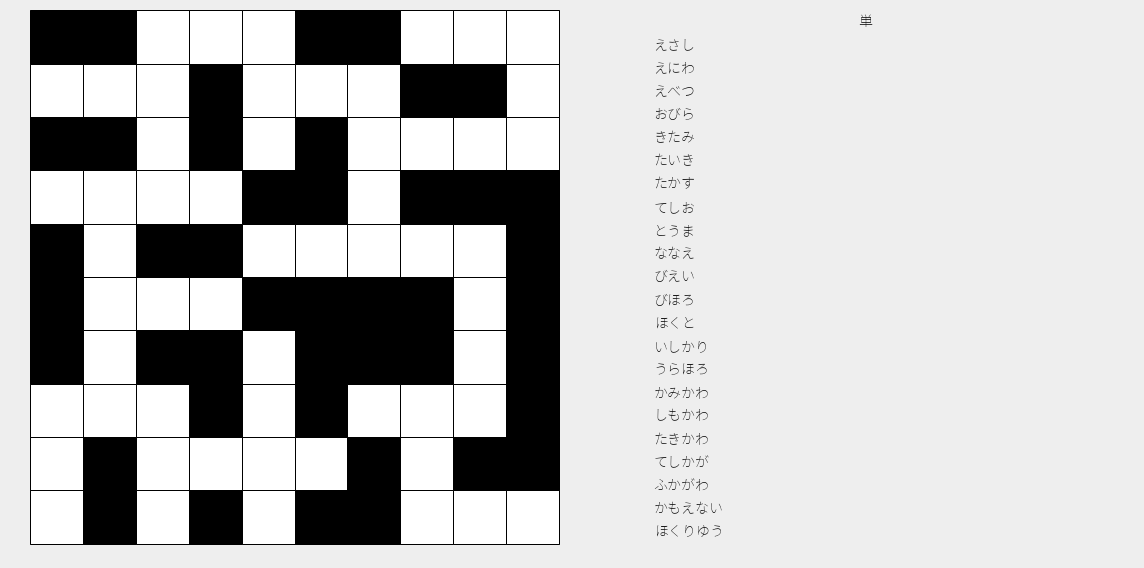

In [45]:
    puzzle.showProblemImage()

## 解答

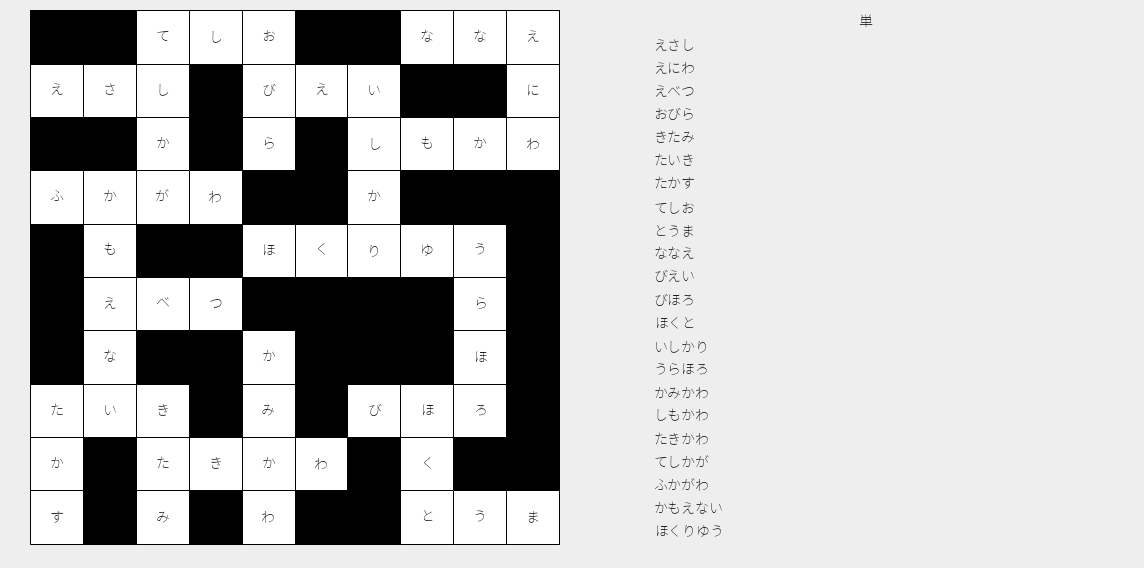

In [46]:
puzzle.showAnswerImage()

これで、クロスワード自動生成ツールの紹介は終わりになります。
ここからは目的関数をさらに定義したり、最適化手法を追加したりして、自由に拡張してください。
このノートの作者は辞書の単語に重み付けをしたり、単語の重要性を計算して作業時間を短縮するような処理を追記する予定です。

In [47]:
e_time = time.time() - start
print ("e_time:{0}".format(e_time) + "[s]")

e_time:17.330047130584717[s]
